# 1millionwomentotech SummerOfCode

## Intro to AI Day 2: Classification versus Regression

On day 1, we have tried to forecast a star rating as a number on a continuous scale: star ratings range from 1 to 5, but the way we trained our linear regression model, it sometimes returned a fractional prediction such as 4.37 stars. In general, prediction algorithms that output a number on a continuous scale are called **regression** algorithms. Linear regression is the most famous member of this family.

Sometimes all we really need to know is a binary answer to a question: Is a review bad or good? Is a user's comment abusive or not? Does a marketing email convert to a sale or not? Prediction algorithms that output either "true" or "false" (instead of a number) are called **classification** algorithms. While classification and regression are similar in many respects, there are also a couple of important differences: both regarding the algorithms we can use and how we evaluate them.

For example, assume that the only reviews we are really interested in are those with 1, 2 or 3 stars. Maybe we want to flag dissatisfied customers automatically so that we can review what went wrong and reach out to them. If we don't have the star ratings available for all customers, we want to be able to classify them as either satisfied or dissatisfied based on the textual content of their review alone. Let's introduce a variable ``D_train`` that is true if the customer is dissatisfied (1, 2 or 3 stars), and false if the customer is satisfied (4 stars or better):

In [18]:
def discretize_targets(Y):
    return Y<=3.0

D_train = discretize_targets(Y_train)
print("The training data contains %f %% dissatisfied customers" % (100.*D_train.mean()))
print(D_train[:10])

The training data contains 21.372218 % dissatisfied customers
[False False False False False False False False  True  True]


A simple classifier would be an algorithm that takes a review text and produces either "true" or "false" as an output. While this is often already useful, it doesn't tell us how confident the classifier is about its predictions. Is the algorithm absolutely sure that the review is bad, or is it a 50-50 decision? We may want to handle these cases differently, since some of the algorithm's errors can be more dangerous than others. In general, a classification algorithm can make two different kinds of errors: **false positives** mean that we wrongly flag a satisfied review (``D == false``) as dissatisfied, while **false negatives** mean that we wrongly flag a dissatisfied review (``D == true``) as satisfied. Often we will use our classification algorithm only as a screening filter to flag candidates for manual review. A false positive means that the reviewer has to read a lot of good reviews and confirm that there isn't actually a need to take action.

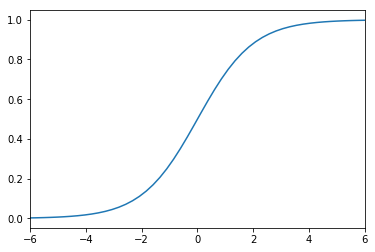

In [19]:
points = numpy.linspace(-6.0, 6.0)
logistic_function = pandas.Series(1/(numpy.exp(-points)+1), index=points)
logistic_function.plot()

In [20]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression().fit(X_train, D_train)
# The predict_proba() method produces a matrix with two columns
# the first column contains the probability for the label being "false" (satisfied customer)
# the second column contains the probability for the label being "true" (dissatisfied customer)
# the sum of both columns is 1
# we select the second column with [:,1]
# [:,0] would select the first column
# [1,:] would select the second row
prob2_train = logreg.predict_proba(X_train)[:,1]
pred2_train = prob2_train > 0.5
max_prob2 = numpy.argmax(prob2_train)
min_prob2 = numpy.argmin(prob2_train)

def analyze_training_example_2(i):
    print("Training example number", i)
    print("True rating = %f stars" % Y_train[i])
    print("Expected to be dissatisfied:", pred2_train[i])
    print("Expected probability of being dissatisfied : %f" % prob2_train[i])
    print("Features = %f / %f" % (X_train[i,0], X_train[i,1]))
    print("Review text = %s" % baby_train[i]['reviewText'])
    
analyze_training_example_2(max_prob2)

Training example number 15920
True rating = 1.000000 stars
Expected to be dissatisfied: True
Expected probability of being dissatisfied : 0.999881
Features = 0.000000 / 1.000000
Review text = uncomfortable


In [21]:
analyze_training_example_2(min_prob2)

Training example number 10566
True rating = 5.000000 stars
Expected to be dissatisfied: False
Expected probability of being dissatisfied : 0.000033
Features = 1.000000 / 0.000000
Review text = work perfect


# Intermediate HW

Change the treshold from 0.5 to 0.2, and rerun the code.

Give a commentary in plain English about how that changed precision and recall. What does that mean? What is now included that wasn't before? What part of it is good? What is bad from our Task perspective. Remember: our task was to identify Dissatisfied reviews.

https://en.wikipedia.org/wiki/Precision_and_recall

In [22]:
from sklearn.metrics import precision_score, recall_score
precision2 = precision_score(D_train, pred2_train)
recall2 = recall_score(D_train, pred2_train)
print("For the default threshold (0.5) we get precision = %f "
      "and recall = %f" % (precision2, recall2))

For the default threshold (0.5) we get precision = 0.605600 and recall = 0.098618


Precision as function of threshold:


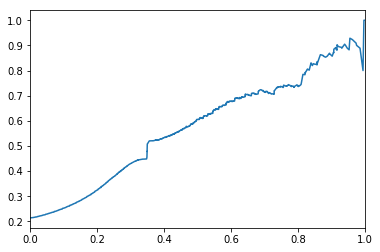

In [23]:
from sklearn.metrics import precision_recall_curve
all_precision2, all_recall2, all_thresh2 = precision_recall_curve(
    D_train, prob2_train)
print("Precision as function of threshold:")
pandas.Series(all_precision2[:-1], index=all_thresh2).plot()

Recall as function of threshold:


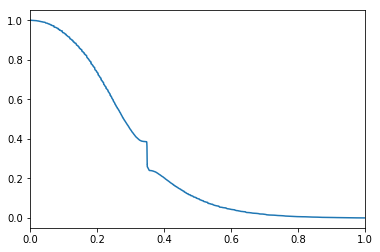

In [24]:
print("Recall as function of threshold:")
pandas.Series(all_recall2[:-1], index=all_thresh2).plot()

Recall as function of precision:


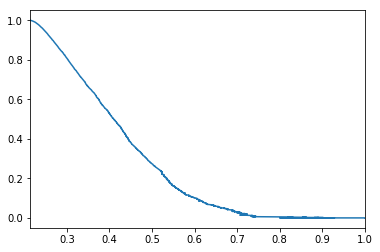

In [25]:
print("Recall as function of precision:")
pandas.Series(all_recall2[:-1], index=all_precision2[:-1]).plot()

Now the precision is 0.484331 and the recall is 0.158186


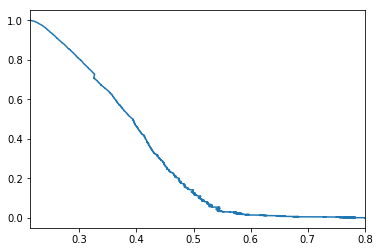

In [26]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB
nb = GaussianNB().fit(X_train, D_train)
prob3_train = nb.predict_proba(X_train)[:,1]
pred3_train = prob3_train>0.5
precision3 = precision_score(D_train, pred3_train)
recall3 = recall_score(D_train, pred3_train)
print("Now the precision is %f and the recall is %f" % (precision3, recall3))
all_precision3, all_recall3, all_thresh3 = precision_recall_curve(
    D_train, prob3_train)
pandas.Series(all_recall3[:-1], index=all_precision3[:-1]).plot()

Chapter 6 of NLTK describes Naive-Bayes http://www.nltk.org/book/ch06.html

# TensorFlow

Linear Regression

Step 1: Make sure you follow installation guide of TensorFlow and then you will be able to import it. https://www.tensorflow.org/

In [27]:
import tensorflow as tf
feat_cols = [tf.feature_column.numeric_column(key="fpos"),
             tf.feature_column.numeric_column(key="fneg")]
model = tf.estimator.LinearRegressor(feature_columns=feat_cols)
get_training_data = tf.estimator.inputs.numpy_input_fn(
                     x={"fpos" : X_train[:,0], "fneg" : X_train[:,1]},
                     y=Y_train, num_epochs=None, shuffle=True)

model.train(input_fn=get_training_data, steps=5000)


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_id': 0, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_is_chief': True, '_master': '', '_session_config': None, '_task_type': 'worker', '_save_summary_steps': 100, '_tf_random_seed': None, '_service': None, '_save_checkpoints_steps': None, '_model_dir': '/tmp/tmp88oyigm2', '_num_worker_replicas': 1, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f149a7be358>, '_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmp88oyigm2/model.ckpt.
INFO:tensorflow:step = 1, loss = 2398.0
INFO:tensorflow:global_step/sec: 739.663
INFO:tensorflow:step = 101, loss = 259.408 (0.137 sec)
INFO:tensorflow:global_step/sec: 725.27
INFO:tensorflow:step = 201, loss = 194.693 (0.137 sec)
INFO:tensorflow:global_step/sec: 781.081
INFO:tensorflow:step = 301, lo

In [28]:
eval_training_data = tf.estimator.inputs.numpy_input_fn(
                     x={"fpos":X_train[:,0], "fneg": X_train[:,1]},
                     num_epochs=1, shuffle=False)
pred_train_tf = numpy.array([item['predictions'][0] for item in 
                         model.predict(input_fn=eval_training_data)])
mae_train_tf = mean_absolute_error(pred_train_tf, Y_train)
print("The mean absolute error on the training data is %f stars" 
      % mae_train_tf)

INFO:tensorflow:Restoring parameters from /tmp/tmp88oyigm2/model.ckpt-5000
The mean absolute error on the training data is 0.843144 stars


# NLTK Built In Sentiment Analyzer

In [64]:
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import mark_negation
examples_negation = ["This product wasn't bad.",
                     "This is not a bad product.",
                     "This product was bad.",
                     "This is a bad product."]

for sentence in examples_negation:
    tokens_with_negation = mark_negation(word_tokenize(sentence.lower()))
    print("Sentence =", sentence)
    print(tokens_with_negation)

negated_stopwords = set(x+"_NEG" for x in eng_stopwords)
all_stopwords = eng_stopwords.union(negated_stopwords)        # set union
    
def tokenize_with_negation(text):
    # split text into lower-case tokens, removing all-punctuation tokens and stopwords
    tokens = []
    for sentence in sent_tokenize(text):
        pretokens = word_tokenize(sentence.lower())
        pretokens = [x for x in pretokens if any(i.isalpha() for i in x)]
        pretokens = mark_negation(pretokens)
        tokens.extend(x for x in pretokens if x not in all_stopwords)
    return tokens

print(baby_train[31]['reviewText'])
print(tokenize_with_negation(baby_train[31]['reviewText']))

Sentence = This product wasn't bad.
['this', 'product', 'was', "n't", 'bad_NEG', '.']
Sentence = This is not a bad product.
['this', 'is', 'not', 'a_NEG', 'bad_NEG', 'product_NEG', '.']
Sentence = This product was bad.
['this', 'product', 'was', 'bad', '.']
Sentence = This is a bad product.
['this', 'is', 'a', 'bad', 'product', '.']
I did a lot of researching on what baby journal to buy and settled on this one and I did not regret it even for a second. This book is perfect! You can keep track of anything your baby does, from eating and sleeping and diapering to all the other things they do like first smile and first laugh. I only wish that instead of being 3 months it would be longer, like 6 months or even 1 year. I would definitely recommend for the first months of your baby's life.
['lot', 'researching', 'baby', 'journal', 'buy', 'settled', 'one', 'regret_NEG', 'even_NEG', 'second_NEG', 'book', 'perfect', 'keep', 'track', 'anything', 'baby', 'eating', 'sleeping', 'diapering', 'things

In [65]:
all_positive_words = positive_words.union({x+"_NEG" for x in negative_words})
all_negative_words = negative_words.union({x+"_NEG" for x in positive_words})

def pos_neg_fraction_with_negation(text):
    tokens = tokenize_with_negation(text)
    # count how many positive and negative words occur in the text
    count_pos, count_neg = 0, 0
    for t in tokens:
        if t in all_positive_words:
            count_pos += 1
        if t in all_negative_words:
            count_neg += 1
    count_all = len(tokens)
    if count_all != 0:
        return count_pos/count_all, count_neg/count_all
    else:  # avoid division by zero
        return 0., 0.
    
pos_example = 'This is a good, great, fantastic, amazing, wonderful, super product!!!'
neg_example = 'This is a bad, atrocious, terrible, dreadful, awful, abysmal product!!!'
print(pos_neg_fraction_with_negation(pos_example))
print(pos_neg_fraction_with_negation(neg_example))    

(0.8571428571428571, 0.0)
(0.0, 0.8571428571428571)


In [66]:
pos_example_neg = 'This is not a good, great, fantastic, amazing, wonderful, super product!!!'
neg_example_neg = 'This is not a bad, atrocious, terrible, dreadful, awful, abysmal product!!!'
print(pos_neg_fraction_with_negation(pos_example_neg))
print(pos_neg_fraction_with_negation(neg_example_neg))    

(0.0, 0.8571428571428571)
(0.8571428571428571, 0.0)


In [69]:
def dataset_to_matrix_with_neg(data):
    return numpy.array([list(pos_neg_fraction_with_negation(item['reviewText'])) for item in data])

X_train_neg = dataset_to_matrix_with_neg(baby_train)

In [71]:
lreg_neg = LinearRegression().fit(X_train_neg, Y_train)
pred_train_neg = lreg_neg.predict(X_train_neg)
mae_train_with_neg = mean_absolute_error(pred_train_neg, Y_train)
print("Now the mean absolute error on the training data is %f stars" % mae_train_with_neg)

Now the mean absolute error on the training data is 0.816299 stars


# Random Forest

In [72]:
from sklearn.ensemble import RandomForestRegressor
rf_neg = RandomForestRegressor().fit(X_train_neg, Y_train)
pred_train_rf_neg = rf_neg.predict(X_train_neg)
mae_train_rf_neg = mean_absolute_error(pred_train_rf_neg, Y_train)
print("A nonlinear regressor achieves a MAE of %f stars" % mae_train_rf_neg)

A nonlinear regressor achieves a MAE of 0.715708 stars


# Short-List Promising Models

Notes:

If the data is huge, you may want to sample smaller training sets so you can train many different
models in a reasonable time (be aware that this penalizes complex models such as large neural nets
or Random Forests).
Once again, try to automate these steps as much as possible.

1. Train many quick and dirty models from different categories (e.g., linear, naive Bayes, SVM, Random Forests, neural net, etc.) using standard parameters.
2. Measure and compare their performance. For each model, use N-fold cross-validation and compute the mean and standard deviation of the performance measure on the N folds.
3. Analyze the most significant variables for each algorithm.
4. Analyze the types of errors the models make. What data would a human have used to avoid these errors?
5. Have a quick round of feature selection and engineering.
6. Have one or two more quick iterations of the five previous steps.
7. Short-list the top three to five most promising models, preferring models that make different types of errors.

Source: p. 646. Hands-on Machine Learning

# Advanced Homework

- Add features
- Explain which features you chose, implement them, and write a commentary on your results
- Feel welcome to use NLTK's built-in sentiment analyzer or any other research that you can find and understand